In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv

--2025-10-18 12:38:42--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80876 (79K) [text/plain]
Saving to: ‘course_lead_scoring.csv.1’

course_lead_scoring 100%[===================>]  78.98K  --.-KB/s    in 0.02s   

2025-10-18 12:38:44 (4.48 MB/s) - ‘course_lead_scoring.csv.1’ saved [80876/80876]



In [3]:
df = pd.read_csv("course_lead_scoring.csv")

In [4]:
df

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1
...,...,...,...,...,...,...,...,...,...
1457,referral,manufacturing,1,NaN,self_employed,north_america,4,0.53,1
1458,referral,technology,3,65259.0,student,europe,2,0.24,1
1459,paid_ads,technology,1,45688.0,student,north_america,3,0.02,1
1460,referral,NaN,5,71016.0,self_employed,north_america,0,0.25,1


In [5]:
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [6]:
categorical = [column for column in df.columns if df[column].dtypes == "object"]
categorical

['lead_source', 'industry', 'employment_status', 'location']

In [7]:
numerical = [column for column in df.columns if column not in categorical]

In [8]:
numerical.remove("converted")

In [9]:
numerical

['number_of_courses_viewed',
 'annual_income',
 'interaction_count',
 'lead_score']

In [10]:
df[categorical].isnull().sum()

lead_source          128
industry             134
employment_status    100
location              63
dtype: int64

In [11]:
df[categorical] = df[categorical].fillna("NA")

In [12]:
df[numerical] = df[numerical].fillna(0)

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [15]:
assert len(df_train) + len(df_val) + len(df_test) == df.shape[0]

In [16]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [17]:
y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

del df_train['converted']
del df_val['converted']
del df_test['converted']

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

### Question 1

In [19]:
from sklearn.metrics import roc_auc_score
auc_scores = {}

for column in numerical:
    score = roc_auc_score(y_train, df_train[column])
    if score < 0.5:
        score = roc_auc_score(y_train, -df_train[column])
    auc_scores[column] = round(score,2)
sorted(auc_scores.items(), key=lambda kv: kv[1], reverse = True)

[('number_of_courses_viewed', 0.76),
 ('interaction_count', 0.74),
 ('lead_score', 0.61),
 ('annual_income', 0.55)]

### Question 2

In [20]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

# model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model = LogisticRegression(solver='lbfgs', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

/Users/oluwadaraadedeji/anaconda3/envs/ml-zoomcamp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [21]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)
# converted_decision = (y_pred >= 0.5)
# (y_val == converted_decision).mean()

0.9211964337072189

In [22]:
categorical + numerical

['lead_source',
 'industry',
 'employment_status',
 'location',
 'number_of_courses_viewed',
 'annual_income',
 'interaction_count',
 'lead_score']

### Question 3

In [23]:
def confusion_matrix_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)
    
    return df_scores

In [24]:
df_scores = confusion_matrix_dataframe(y_val, y_pred)

In [25]:
df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,171,122,0,0
10,0.1,168,93,3,29
20,0.2,166,73,5,49
30,0.3,164,49,7,73
40,0.4,158,32,13,90
50,0.5,153,25,18,97
60,0.6,144,15,27,107
70,0.7,135,10,36,112
80,0.8,127,7,44,115
90,0.9,99,6,72,116


In [26]:
df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)

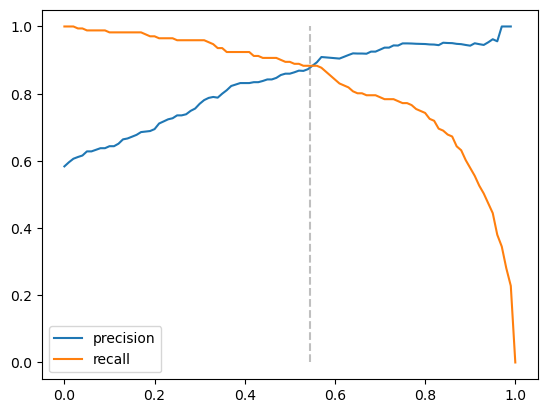

In [27]:
plt.plot(df_scores.threshold, df_scores.p, label='precision')
plt.plot(df_scores.threshold, df_scores.r, label='recall')

plt.vlines(0.545, 0, 1, color='grey', linestyle='--', alpha=0.5)

plt.legend()
plt.show()

### Question 4

In [28]:
df_scores['f1'] = 2 * df_scores.p * df_scores.r / (df_scores.p + df_scores.r)

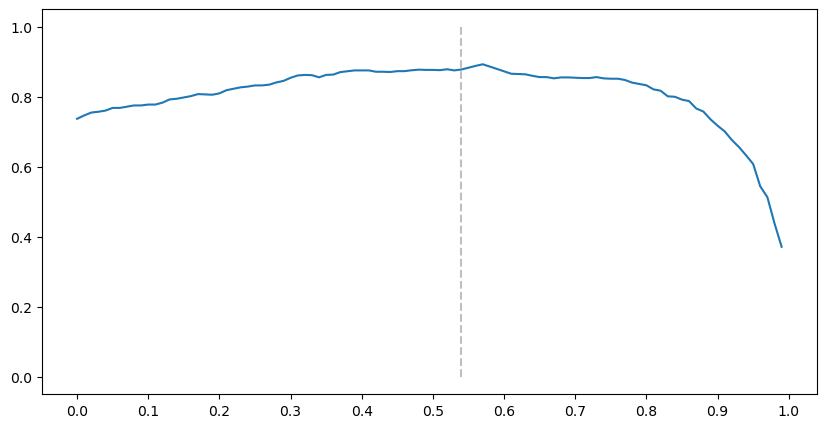

In [29]:
plt.figure(figsize=(10, 5))

plt.plot(df_scores.threshold, df_scores.f1)
plt.vlines(0.54, 0, 1, color='grey', linestyle='--', alpha=0.5)

plt.xticks(np.linspace(0, 1, 11))
plt.show()

### Question 5

In [30]:
from sklearn.model_selection import KFold

In [39]:
columns = categorical + numerical
def train(df_train, y_train, C=1.0):
    dicts = df_train[columns].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter = 1000)
    # model = LogisticRegression(solver='lbfgs', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model

def predict(df, dv, model):
    dicts = df[columns].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [40]:
scores = []

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.converted.values
    y_val = df_val.converted.values

    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.822 +- 0.036


### Question 6

In [43]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for C in [0.000001, 0.001, 1]:
    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.converted.values
        y_val = df_val.converted.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%4s, %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=1e-06, 0.560 +- 0.024
C=0.001, 0.867 +- 0.029
C=   1, 0.822 +- 0.036
